In [1]:
!pip install transformers

In [2]:
from transformers import pipeline
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.metrics import f1_score, confusion_matrix

In [4]:
#Create Instance of sentiment analysis using pipeline
classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0


In [5]:
type(classifier)

transformers.pipelines.text_classification.TextClassificationPipeline

In [6]:
#Output is a dictionary with Label and score
classifier("I like deep learning")

[{'label': 'POSITIVE', 'score': 0.9997264742851257}]

In [7]:
classifier([
  "I want to learn this course.",
  "I am unable to understand this course because my prerequisites are not clear."])

[{'label': 'POSITIVE', 'score': 0.9974923133850098},
 {'label': 'NEGATIVE', 'score': 0.9997028708457947}]

In [8]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [9]:
classifier = pipeline("sentiment-analysis", device = device)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0


In [10]:
#Reading the dataset
df = pd.read_csv('Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


<Axes: >

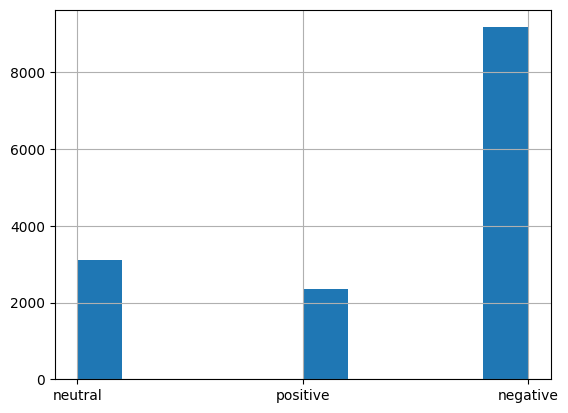

In [11]:
#Checking the labels
df = df[['airline_sentiment', 'text']].copy()
df['airline_sentiment'].hist()

In [12]:
#Removing the 'neutral' class
df = df[df.airline_sentiment != 'neutral'].copy()
label_map = {'positive': 1, 'negative': 0}
df['labels'] = df['airline_sentiment'].map(label_map)
df.head()

,airline_sentiment,text,labels
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [13]:
len(df)

11541

In [14]:
df = df[['text', 'labels']]
df.head()

,text,labels
1,@VirginAmerica plus you've added commercials t...,1
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0
5,@VirginAmerica seriously would pay $30 a fligh...,0
6,"@VirginAmerica yes, nearly every time I fly VX...",1


In [15]:
#Passing the dataset through the classifier
texts = df['text'].tolist()
predictions = classifier(texts)

In [16]:
predictions

[{'label': 'POSITIVE', 'score': 0.6070827841758728},
 {'label': 'NEGATIVE', 'score': 0.9973449110984802},
 {'label': 'NEGATIVE', 'score': 0.9995823502540588},
 {'label': 'NEGATIVE', 'score': 0.9854250550270081},
 {'label': 'POSITIVE', 'score': 0.9553212523460388},
 {'label': 'POSITIVE', 'score': 0.9827088117599487},
 {'label': 'POSITIVE', 'score': 0.9994851350784302},
 {'label': 'POSITIVE', 'score': 0.9993509650230408},
 {'label': 'POSITIVE', 'score': 0.9940821528434753},
 {'label': 'POSITIVE', 'score': 0.9863133430480957},
 {'label': 'POSITIVE', 'score': 0.9996304512023926},
 {'label': 'NEGATIVE', 'score': 0.9980512857437134},
 {'label': 'POSITIVE', 'score': 0.9964436888694763},
 {'label': 'NEGATIVE', 'score': 0.9968666434288025},
 {'label': 'POSITIVE', 'score': 0.9787647724151611},
 {'label': 'POSITIVE', 'score': 0.9995218515396118},
 {'label': 'NEGATIVE', 'score': 0.9954516291618347},
 {'label': 'POSITIVE', 'score': 0.9995624423027039},
 {'label': 'POSITIVE', 'score': 0.999874830245

In [17]:
#Transform positive label to 1 and negative to zero
ypred = []
for i in predictions:
  if i['label'] == 'POSITIVE':
    ypred.append(1)
  else:
    ypred.append(0)

len(ypred)

11541

In [18]:
#Finding the accuracy
ypred = np.array(ypred)
print("acc:", np.mean(df['labels'] == ypred))

acc: 0.8898708950697514


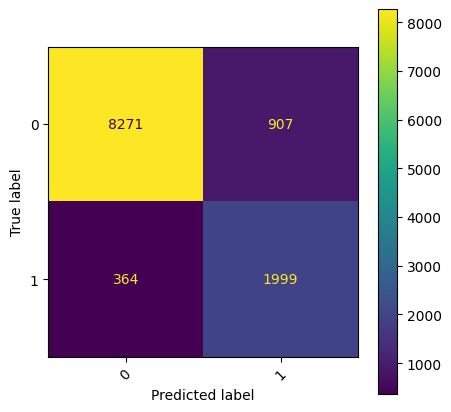

In [19]:
#All the performance metrics
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay

cm = confusion_matrix(df['labels'], ypred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= [0, 1])
disp.plot(xticks_rotation=45)
fig = disp.ax_.get_figure()
fig.set_figwidth(5)
fig.set_figheight(5)
plt.show()

In [22]:
Accuracy = accuracy_score(df['labels'], ypred, normalize=True)
Precision = precision_score(df['labels'], ypred, average = 'macro')  # macro calculate the average value of classes.
Recall = recall_score(df['labels'], ypred, average = 'macro')
F1_Score = f1_score(df['labels'], ypred, average = 'macro')

print('Accuracy : ', Accuracy)
print(" ")
print('Precision : ', Precision)
print(" ")
print('Recall : ', Recall)
print(" ")
print('F1_Score : ', F1_Score)
print(" ")


Accuracy :  0.8898708950697514
 
Precision :  0.822866552878038
 
Recall :  0.8735676271257871
 
F1_Score :  0.8437126867995365
 
